<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/W8-T2/W8_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 8 Part 2
# Generative Adversarial Networks (GANs)

__Instructor__: Konrad Kording

__Content creators:__ Arash Ash, Richard Lange

---
# Tutorial Objectives

This tutorial will uncover Generative Adversarial Networks (GANs) and teach you how to use them to solve all kinds of cool computer vision tasks. In particular, we will:

* First, understand how GANs are trained
* Generate Animal Faces with MLPs and ConvNets
* Discover the most common failure mode of GANs
* How to train conditionally on the class label
* How to generate images controllably using a pre-trained classifier 
* How to learn an image-to-image mapping using unpaired images using CycleGANs

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)

my_pennkey = 'value' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


In [ ]:
# @title Slides
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQTsDQET4TdoyJv_Ql_wm6ct9cxFMVghMXnqGYutHJW_3io7D1wM_F0cOj1-31KwQ-gV5eHWSni77mO/embed?start=false&loop=false&delayms=3000" frameborder="0" width="480" height="299" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [ ]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import time
import random
import pathlib

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# @title Seeding for reproducibility
seed = 522
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# @title Downloads
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip 

!git clone https://github.com/arashash/celeb-classifier
!mv /content/celeb-classifier/pretrained_classifier.pth pretrained_classifier.pth

In [ ]:
# @title Animal Faces Dataset

H = 32
W = 32
C = 3
num_classes = 3

def get_data_loaders(batch_size):
  # define the transform done only during training
  augmentation_transforms = [transforms.RandomHorizontalFlip()]

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size, pin_memory=True,
                                shuffle=True, num_workers=0, drop_last=True)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=0)
  
  return img_train_loader, img_test_loader

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [ ]:
# @title Helper functions
def imshow(img):
    img -= torch.min(img)
    img *= 255/torch.max(img)
    npimg = img.numpy().astype(np.uint8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def progress(batch, loss, batches):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{batch}'
            max='{batches}',
            style='width: 100%'
        >
            {batch}
        </progress>
    """.format(loss=loss, batch=batch, batches=batches))

class Classifier(nn.Module):
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [ ]:
# @title Copy of rsample, log_p_x, kl_q_p, BiasLayer, and ConvVAE from T1
my_dataset_size = C, H, W
def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    eps = torch.randn(b, n_samples, kplus1-1, device=phi.device)
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    return eps*sig.view(b,1,1) + mu.view(b,1,kplus1-1)

def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]
    """
    b, n, k = zs.size()
    mu_p = torch.zeros((k,), device=phi.device)
    sig_p = torch.ones((k,), device=phi.device)
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs - mu_p.view(1,1,k))**2 / sig_p.view(1,1,k)**2 - torch.log(sig_p.view(1,1,k))
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

class BiasLayer(nn.Module):
    def __init__(self, shape):
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape)
        self.bias = nn.Parameter(init_bias, requires_grad=True)
    
    def forward(self, x):
        return x + self.bias

class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()
        
        # With padding=0, the number of pixels cut off from each image dimension
        # is filter_size // 2. Double it to get the amount of pixels lost in
        # width and height per Conv2D layer, or added back in per 
        # ConvTranspose2D layer.
        filter_reduction = 2 * (filter_size // 2)

        # After passing input through two Conv2d layers, the shape will be
        # 'shape_after_conv'. This is also the shape that will go into the first
        # deconvolution layer in the decoder
        self.shape_after_conv = (num_filters,
                                 my_dataset_size[1]-2*filter_reduction,
                                 my_dataset_size[2]-2*filter_reduction)
        flat_size_after_conv = self.shape_after_conv[0] \
            * self.shape_after_conv[1] \
            * self.shape_after_conv[2]

        # Define the recognition model (encoder or q) part
        self.q_bias = BiasLayer(my_dataset_size)      
        self.q_conv_1 = nn.Conv2d(my_dataset_size[0], num_filters, 5)
        self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
        self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

        # Define the generative model (decoder or p) part
        self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
        self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
        self.p_deconv_2 = nn.ConvTranspose2d(num_filters, my_dataset_size[0], 5)
        self.p_bias = BiasLayer(my_dataset_size)

        # Define a special extra parameter to learn scalar sig_x for all pixels
        self.log_sig_x = nn.Parameter(torch.zeros(()))
    
    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        s = self.q_bias(x)
        s = F.relu(self.q_conv_1(s))
        s = F.relu(self.q_conv_2(s))
        flat_s = s.view(s.size()[0], -1)
        phi = self.q_fc_phi(flat_s)
        return phi

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        # Note that for the purposes of passing through the generator, we need
        # to reshape zs to be size [b*n,k]
        b, n, k = zs.size()
        s = zs.view(b*n, -1)
        s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
        s = F.relu(self.p_deconv_1(s))
        s = self.p_deconv_2(s)
        s = self.p_bias(s)
        mu_xs = s.view(b, n, -1)
        return mu_xs
    
    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        # Compute ELBO for a batch of inputs
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

def train_vae(vae, dataset, epochs=10, n_samples=16):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-6)
    elbo_vals = []
    vae.to(device)
    vae.train()
    loader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)
    for epoch in trange(epochs, desc='Epochs'):
        for im, _ in tqdm(loader, total=len(dataset)//100, desc='Batches', leave=False):
            im = im.to(device)
            opt.zero_grad()
            loss = -vae.elbo(im)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
    vae.to('cpu')
    vae.eval()
    return elbo_vals

---
# Section 1: wrapping up VAE - 15 mins

Video available at https://youtube.com/watch?v=F5FBVoQKtAY


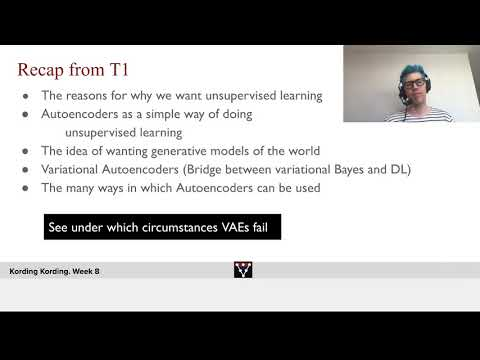

In [ ]:
#@title Video : 
try: t1;
except NameError: t1=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="F5FBVoQKtAY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 1.1: why vanilla VAEs fail?

Now that we have a pretty good idea about Auto-encoders let's see why they fail in practice? Let's train a VAE on the Animal Faces dataset to see whether we can generate cute cat faces?

first, remembering the Animal Faces dataset:

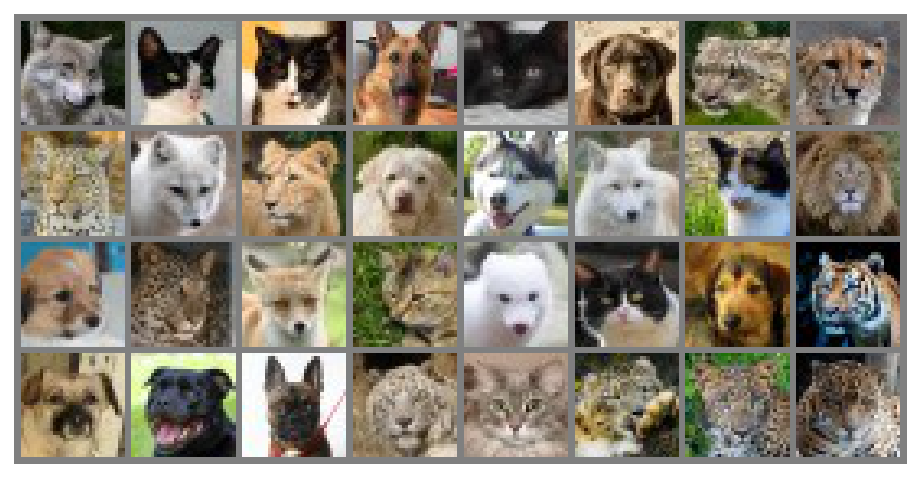

In [ ]:
batch_size = 32
# creating the dataloaders which gives us batches of samples
img_train_loader, img_test_loader = get_data_loaders(batch_size)

# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images, nrow=8))

In [ ]:
def train_vae(vae, loader, epochs=5, n_samples=1):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-5)
    
    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)

    elbo_vals = []
    vae.to(device)
    vae.train()
    steps = 0
    for epoch in range(epochs):
        for im, _ in loader:
            opt.zero_grad()
            loss = -vae.elbo(im.to(device), n_samples)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
            progress_bar.update(progress(steps, loss.item(), max_steps))
            steps += 1

    vae.to('cpu')
    vae.eval()
    return elbo_vals

K = 15
vae = ConvVAE(K=K)

## Uncomment below to test your function
elbo_vals = train_vae(vae, img_train_loader, n_samples=10)
zs = torch.randn(batch_size, 1, K)
images = vae.generate(zs).detach().view(batch_size, C, H, W)
imshow(make_grid(images, nrow=8))

In [ ]:
#@markdown Why do you think the generated images don't have realistic distributions (e.g, not even colored!)?
w8_why_different_distribution = '' #@param {type:"string"}

---
# Section 2: Intro to GANs - 40 mins
As opposed to Auto-encoders, GANs show us an intuitive way of learning representations that can be easily sampled. Let's see how,

In [ ]:
#@title Video
try: t2;
except NameError: t2=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ye5P78eKOVM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Let's first review the code from Week 3 (MLPs). We construct a model that can be defined both as a generator and a discriminator.


In [ ]:
class MLP(nn.Module):
    def __init__(self, actv, input_units, hidden_units_list, output_units,
                 out_actv=None):
        super(MLP, self).__init__()

        # Initialize layers of MLP
        self.layers = nn.ModuleList()

        # Loop over layers and create each one
        in_units = input_units
        for units in hidden_units_list:
          out_units = units

          # create the linear layer
          self.layers += [nn.Linear(in_units, out_units)]
          in_units = out_units  

          # create the activation layer
          exec('self.activation = nn.%s'%actv)  
          self.layers += [self.activation]

        # Create final linear layer
        self.out = nn.Linear(in_units, output_units)

        # create output activation layer if exist
        self.out_actv = out_actv
        if out_actv:
          exec('self.out_actv = nn.%s'%out_actv) 

    def forward(self, x):

        # Flatten inputs to 2D (if more than that)
        x = x.view(x.shape[0], -1)  

        # Get activations of each layer
        for layer in self.layers:
          x = layer(x)

        # Get outputs
        x = self.out(x) 
        
        # apply output activation if exist
        if self.out_actv:
          x = self.out_actv(x)

        return x

## Exercise 2.1: Discriminator Loss
Let's implement the discriminator loss function that is introduced in the video, which is:

$$
J_{D}=-\frac{1}{m} \sum_{i=1}^{m} y_{i} \log D\left(x_{i}\right)+\left(1-y_{i}\right) \log \left(1-D\left(x_{i}\right)\right)
$$

Note that it is often the standard to calculate this loss in two steps using equal batches ($m=2m'$) of only fake and only real examples. So let's rewrite it accordingly,

$$
J_{D}=-\frac{1}{2m'} \sum_{i=1}^{real} \log D\left(x_{i}\right)-\frac{1}{2m'}\sum_{i=1}^{fake}\log \left(1-D\left(x_{i}\right)\right)
$$

Note that $log$ function goes to infinity near zero, which would make the loss infinite. For this reason, `nn.BCELoss` clamps its log function outputs to be greater than or equal to -100. This way, we can always have a finite loss value and a linear, backward method. we can achieve this by using `torch.clamp(x, -100, 0)` after all $log$ computations.

Hint: You will need to use these functions in this order:

1.   `torch.log(x)`
2.   `torch.clamp(x, -100, 0)`
3.   `torch.mean(x)`

In [ ]:
def get_disc_BCE_loss(disc_real_pred, disc_fake_pred):
    '''
    Function for returning a BCE loss of discriminator

    Parameters:
        disc_real_pred: probs of real predicted by the disc
        using a real batch, (num_samples, 1)
        probs of real predicted by the disc
        using a fake batch, (num_samples, 1)

    Returns:
        BCE loss of the two prediction batches, a scalar
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the disc BCE loss function")
    ####################################################################

    # BCE loss of the real batch
    disc_real_loss = ...

    # BCE loss of the fake batch
    disc_fake_loss = ...

    # Average loss
    disc_loss = ...
    return disc_loss


def get_disc_BCE_loss(disc_real_pred, disc_fake_pred):
    '''
    Function for returning a BCE loss of discriminator

    Parameters:
        disc_real_pred: probs of real predicted by the disc
        using a real batch, (num_samples, 1)
        probs of real predicted by the disc
        using a fake batch, (num_samples, 1)

    Returns:
        BCE loss of the two prediction batches, a scalar
    '''

    # BCE loss of the real batch
    disc_real_loss = -torch.mean(torch.clamp(torch.log(disc_real_pred), -100, 0))

    # BCE loss of the fake batch
    disc_fake_loss = -torch.mean(torch.clamp(torch.log(1 - disc_fake_pred), -100, 0))

    # Average loss
    disc_loss = (disc_real_loss + disc_fake_loss) / 2
    return disc_loss

### Uncomment below to test your function
test_value = get_disc_BCE_loss(torch.tensor([0.9, 0.9]),
                              torch.tensor([0.1, 0.2]))
true_value = 0.135
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

Before we start the training, we need the data and model. Let's define our data loaders and the MLP model for discriminators.

We will first define an MLP using two hidden layers and a single Sigmoid activated output unit that predicts the probability of realness of inputs.

In [ ]:
# PReLU is like LeakyRelU
# but the negative slope is a trainalble parameter
actv = 'PReLU()'

disc = MLP(actv=actv,
          input_units = C*H*W,
          hidden_units_list = [256, 128],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

## Step 1: Train a Discriminator

Now we are going to train the discriminator using this loss function on random fake and real images. We will generate fake images where their pixel values are drawn from a standard normal distribution (i.e., white noise).

In [ ]:
 def train_discriminator(disc, loader, epochs=1):
    disc_opt = optim.Adam(disc.parameters(), lr=2e-4)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    disc_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):

          real = real.to(device)

          fake = torch.randn(real.shape).to(device)

          ### Train Discriminator ###
          disc_real_pred = disc(real)
          disc_fake_pred = disc(fake)

          # Calculate discriminator loss
          disc_loss = get_disc_BCE_loss(disc_real_pred, disc_fake_pred)

          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Update gradients
          disc_loss.backward()

          # Update optimizer
          disc_opt.step()

          # update the loss trackers
          disc_losses.append(disc_loss.item())
          
          # update the progress bar
          steps += 1
          progress_bar.update(progress(steps, disc_losses[-1], max_steps))
    
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

    return disc

### Uncomment below to test your function
disc_white_noise = train_discriminator(disc, img_train_loader)

In [ ]:
### Uncomment below to test your model
fake = torch.randn(1, C*H*W).to(device)
disc_fake_pred = disc(fake)
'Probability of real on the fake example is %.3f'%disc_fake_pred.item()

In [ ]:
#@markdown If we add 1.0 to a fake sample from white noise distribution (you could try it with the code above!), do you think the model can discriminate it from real? Why?
w8_does_it_work_with_another_white_noise= '' #@param {type:"string"}

I hope you could see that distinguishing only between real and white noise is not enough. The discriminator needs to differentiate between all possible fake distributions. Therefore there should be a smart process that able to generate these fake distributions. Let's see how,

## Step 2: Train a Generator

In [ ]:
#@title Video
try: t3;
except NameError: t3=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="wL2xy9HTcLc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 2.2: Generator Loss

Here's the BCE generator loss,
$$
J_{G}=-J_{D}=\frac{1}{m} \sum_{i=1}^{m} y_{i} \log D\left(x_{i}\right)+\left(1-y_{i}\right) \log \left(1-D\left(x_{i}\right)\right)
$$

But we should get it in better shape to implement it as we did for the discriminator. First, note that the generator will only be trained with fake examples (since it can not predict real examples). Therefore the first term disappears for the generator loss since $y_i=0$. So we have,

$$
J_{G}=\frac{1}{m} \sum_{i=1}^{fake} \log \left(1-D\left(x_{i}\right)\right)
$$

<img align="right" width="400" height="250" src="https://drive.google.com/uc?id=1iDSMcLkgF6AnDR3846-iBoZUpH-6F9r_">

Furthermore, the following modified loss (proposed in the original [paper](https://arxiv.org/pdf/1406.2661.pdf)) prevents vanishing gradient in the early stages of training when the discriminator job is too easy. It achieves this goal by providing a larger gradient for the generator in the beginning compared to the BCE implementation. The tangent lines in the figure indicate the gradient at the beginning of the training where the generator is producing easy examples for the discriminator, and it has a low probability of being real. Therefore these large slopes in the new loss prevent vanishing gradient at the beginning of the training.

$$
J_{G}=-\frac{1}{m} \sum_{i=1}^{fake} \log \left(D\left(x_{i}\right)\right)
$$

This generator loss can also be implemented with BCE if we switch labels from 0 to 1, i.e., considering fake examples labeled as 1 for the generator. And in practice, this is how we use it with `nn.BCELoss`. And we will implement this way in the last exercise as well. But first, let's practice doing it ourselves from scratch!


In [ ]:
def get_gen_BCE_loss(disc_fake_pred):
    '''
    Function for returning a modified BCE loss for generator

    Parameters:
        probs of real predicted by the disc
        using a fake batch, (num_samples, 1)

    Returns:
        modified BCE loss of the fake prediction batch, a scalar
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the disc BCE loss function")
    ####################################################################

    # modified BCE loss of the fake batch
    gen_fake_loss = ...

    return gen_fake_loss


def get_gen_modified_BCE_loss(disc_fake_pred):
    '''
    Function for returning a modified BCE loss for generator

    Parameters:
        probs of real predicted by the disc
        using a fake batch, (num_samples, 1)

    Returns:
        modified BCE loss of the fake prediction batch, a scalar
    '''
    
    # modified BCE loss of the fake batch
    gen_fake_loss = -torch.mean(torch.clamp(torch.log(disc_fake_pred), -100, 0))

    return gen_fake_loss

### Uncomment below to test your function
test_value = get_gen_modified_BCE_loss(torch.tensor([0.9, 0.9]))
true_value = 0.105
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

Before we start the training, we need the generator model.

Let's define an MLP using two hidden layers, and a single Tanh activated output unit that generates images given a noise vector of size `z_dim`.

In [ ]:
z_dim = 64
gen = MLP(actv=actv,
          input_units = z_dim,
          hidden_units_list = [128, 256],
          output_units = C*H*W,
          out_actv = 'Tanh()').to(device)

Now let's train the generator to fool the white noise discriminator we trained before:

In [ ]:
 def train_generator(disc, gen, loader, epochs=1):
    gen_opt = optim.Adam(gen.parameters(), lr=2e-4)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    gen_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):

          noise = torch.randn(len(real), z_dim).to(device)
          fake = gen(noise)

          ### Train Generator ###
          disc_fake_pred = disc(fake)

          # Calculate discriminator loss
          gen_loss = get_gen_modified_BCE_loss(disc_fake_pred)

          # Zero out the gradients before backpropagation
          gen_opt.zero_grad()

          # Update gradients
          gen_loss.backward()

          # Update optimizer
          gen_opt.step()

          # update the loss trackers
          gen_losses.append(gen_loss.item())
          
          # update the progress bar
          steps += 1
          progress_bar.update(progress(steps, gen_losses[-1], max_steps))
    
    plt.plot(gen_losses, label='Generator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

    return gen

### Uncomment below to test your function
trained_gen = train_generator(disc_white_noise, gen, img_train_loader)

Let's see what the generated images look like!

In [ ]:
### Uncomment below to test your model
noise = torch.randn(24, z_dim).to(device)
images = gen(noise).detach().cpu().view(24, C, H, W)
imshow(make_grid(images, nrow=8))

## Step 3: Learn Discriminator with a Generator

In [ ]:
#@title Video
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="y01DfHZ9_Vw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

We are going to freeze the generator and train the discriminator with it. 

Note that since the generator is needed when calculating the discriminator's loss, we need to call `.detach()` on the generator output (which removes the generator graph from the computational graph of discriminator loss) to ensure that only the discriminator gradients are calculated.

In addition, using only `fake.detach()` in the discriminator loss computation allows us to use it later for the generator loss. Since, by default, after calling `.backward()` all the computational graphs used in the loss calculation will be removed, so if we do not use `fake.detach()`, we will not be able to backward pass through it again in generator loss backpropagation.

In [ ]:
 def train_discriminator_with_gen(disc, get, loader, epochs=1):
    disc_opt = optim.Adam(disc.parameters(), lr=2e-4)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    disc_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):
          real = real.to(device)

          # random noise for the generator
          noise = torch.randn(len(real), z_dim).to(device)
        
          ### Train Discriminator ###
          disc_real_pred = disc(real)
          fake = gen(noise)
          # Next don't forget to give a detached fake to the discriminator
          # since we do not want to backdrop to generator yet 
          disc_fake_pred = disc(fake.detach())

          # Calculate discriminator loss
          disc_loss = get_disc_BCE_loss(disc_real_pred, disc_fake_pred)

          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Update gradients
          disc_loss.backward()

          # Update optimizer
          disc_opt.step()

          # update the loss trackers
          disc_losses.append(disc_loss.item())
          
          # update the progress bar
          steps += 1
          progress_bar.update(progress(steps, disc_losses[-1], max_steps))
    
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

    return disc

### Uncomment below to test your function
disc_white_noise = train_discriminator_with_gen(disc_white_noise, trained_gen, img_train_loader)

## Step 4: Learn Discriminator and Generator together

In [ ]:
#@title Video
try: t5;
except NameError: t5=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6GGdZ5eTNmQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


**Note** that we set $\beta_1$ value of Adam optimizer, which deactivates the gradient's momentum. Why is momentum bad for GANs? Because the data distribution is non-stationary over training (since fake distribution is changing over time), the loss surfaces are kept changing after each update. Hence, a downhill might suddenly turn into an uphill, so sometimes there is no point in keep going in that direction; therefore, momentum, if used carelessly, often makes training more unstable!

Now let's put everything together and see the magic!

In [ ]:
 def train_full_GAN(gen, disc,
                    loader, z_dim, 
                    epochs=5, disp_batch_size = 24):
    gen.to(device).train()
    disc.to(device).train()

    disc_opt = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.0, 0.999))
    gen_opt = optim.Adam(gen.parameters(), lr=3e-4, betas=(0.0, 0.999))

    # fix noise for testing genererator at each epoch
    fix_noise = torch.randn(disp_batch_size, z_dim).to(device)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    gen_losses = []
    disc_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):
          real = real.to(device)
          batch_size = len(real)
          
          # random standard normal noise for generator
          noise = torch.randn(batch_size, z_dim).to(device)

          ### Train Discriminator ###
          # Forward computations
          fake = gen(noise)
          # Next don't forget to give a detached fake to the discriminator
          # since we do not want to backdrop to generator yet 
          disc_fake_pred = disc(fake.detach())
          disc_real_pred = disc(real)

          # Calculate discriminator loss
          disc_loss = get_disc_BCE_loss(disc_real_pred, disc_fake_pred)

          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Update gradients
          disc_loss.backward()

          # Update optimizer
          disc_opt.step()

          ### Train Generator ###
          # Forward computations
          disc_fake_pred = disc(fake)

          # Calculate discriminator loss
          gen_loss = get_gen_modified_BCE_loss(disc_fake_pred)

          # Zero out the gradients before backpropagation
          gen_opt.zero_grad()

          # Update gradients
          gen_loss.backward()

          # Update optimizer
          gen_opt.step()

          # update the loss trackers
          gen_losses.append(gen_loss.item())
          disc_losses.append(disc_loss.item())

          progress_bar.update(progress(steps, (gen_losses[-1], disc_losses[-1]), max_steps))
          steps += 1

        images = gen(fix_noise).detach().cpu().view(disp_batch_size, C, H, W)
        imshow(make_grid(images, nrow=8))
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

z_dim = 128

actv = 'PReLU()'

gen = MLP(actv=actv,
          input_units = z_dim,
          hidden_units_list = [128, 256],
          output_units = C*H*W,
          out_actv = 'Tanh()').to(device)

disc = MLP(actv=actv,
          input_units = C*H*W,
          hidden_units_list = [256, 128],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

### Uncomment below to test your function
train_full_GAN(gen, disc, img_train_loader, z_dim)

In [ ]:
#@markdown Assuming a perfect discriminator, what is the global minimum loss of the generator (hint: what should a perfect generator do)? Is the final generator loss for MLP model close to that value?
w8_is_it_optimal_gen = '' #@param {type:"string"}

---
# Section 3: Convolutional GANs - 20 mins

In [ ]:
#@title Video
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="IxveRWDe-yc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Let's implement a general-purpose ConvNet for both discriminator and generator like the one with MLPs. Don't worry; The implementation is not an exercise, but you need to figure out how `ConvTranspose2d` is working to answer the next question.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, actv, input_channel, hidden_channels, out_actv=None, is_gen=False):
        super(ConvNet, self).__init__()
        self.is_gen = is_gen

        # Initialize layers of MLP
        self.layers = nn.ModuleList()

        # Loop over layers and create each one
        in_channels = input_channel
        for i in range(len(hidden_channels)):
          out_channels = hidden_channels[i] 

          if self.is_gen: # if it is a generator model
            if i > 0:  # if first layer
              self.layers += [nn.ConvTranspose2d(
                                  in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=4, #<--
                                  stride=2, #<----
                                  padding=1 #<---
                              )]
            else:
                self.layers += [nn.ConvTranspose2d(
                      in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=2, #<--
                      stride=1, #<----
                      padding=0 #<---
                  )]
          else:
            self.layers += [nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1
                )]

          in_channels = out_channels
          exec('self.activation = nn.%s'%actv)
          self.layers += [
            self.activation]  

        # Create final layer
        if self.is_gen:  
          self.out = nn.ConvTranspose2d(
                                in_channels=out_channels,
                                out_channels=3,
                                kernel_size=4,
                                stride=2,
                                padding=1,
                            )
        else:
          self.out = nn.Conv2d(
                      in_channels=out_channels,
                      out_channels=1,
                      kernel_size=2,
                      stride=1,
                      padding=0,
                  )
        
        self.out_actv = out_actv
        if out_actv:
          exec('self.out_actv = nn.%s'%out_actv) 

    def forward(self, x):
        if self.is_gen: 
          # make inputs to 1x1 2D with channel noise
          x = x.view(x.shape[0], -1, 1, 1)
        else:
          x = x.view(x.shape[0], -1, H, W)

        # Get activations of each layer
        for layer in self.layers:
          x = layer(x)

        # Get outputs
        x = self.out(x)

        if self.out_actv:
          x = self.out_actv(x)
        return x

In [ ]:
#@markdown Why we use different kernal size and stride in the first ConvTranspose2d?
w8_why_different_filter_in_first_layer_for_gen = '' #@param {type:"string"}

In [ ]:
z_dim = 128
actv = 'PReLU()'
disc = ConvNet(actv=actv,
          input_channel = 3,
          hidden_channels = [128, 256, 512, 1024], 
          out_actv = 'Sigmoid()', is_gen=False)

gen = ConvNet(actv=actv,
          input_channel = z_dim,
          hidden_channels = [1024, 512, 256, 128], 
          out_actv = 'Tanh()', is_gen=True)

### Uncomment below to test your function
train_full_GAN(gen, disc, img_train_loader, z_dim)

In [ ]:
#@markdown The generator BCE loss is diverging, but images are still improving! Why do you think BCE loss fails to measure the actual performance of GANs?
w8_why_bce_is_bad_metric = '' #@param {type:"string"}

---
# GAN Failures

In [ ]:
#@title Video
try: t7;
except NameError: t7=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="u-8mv1MHiec", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 3.1: Visualize Mode Collapse

<img align="right" width="300" height="300" src="https://drive.google.com/uc?id=1-3Fy9r1i_TB9U-j6bmi7CTdb8u2YCjx8">

Now that we have a good idea on what is Mode Collapse let's try to see it happen in real-time.


For this exercise, you could follow these steps:
1.   Familiarize yourself with the interface
2.   In the Data Distribution tab to the right of GAN Lab logo, click on the last option with a yellow marker sign
3.   Draw a distribution similar to the shown example (one pile being denser than others) and press APPLY
4.   Press the play button to start training
5.   Wait to see where the distribution generally lies






In [ ]:
# @title GanLab
from IPython.display import HTML
HTML('<iframe width="1500" height="660" src="https://poloclub.github.io/ganlab/" allowfullscreen></iframe>')

Reminder: The **Nash equilibrium** is a concept of game theory where the optimal outcome of a game is one where no player has an incentive to deviate from their chosen strategy after considering an opponent's choice.

In [ ]:
#@markdown We saw that the generator distribution is going to converge at the big pile. Why do you think this Mode collapse is a desirable output for the game? Is it a Nash equilibrium?
w8_is_it_Nash_equilibrium = '' #@param {type:"string"}

---
# Section 4: Conditional GANs - 20 mins

In [ ]:
#@title Video
try: t8;
except NameError: t8=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="XqhbOsydKo0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 4.1: Augment Inputs with Labels

<img align="right" width="250" height="200" src="https://drive.google.com/uc?id=1VjxdcjpCA_DLm3MorRoaeWTJgpg6HiEa">

To train a conditional GAN, we could extend the models' input to accept a one-hot encoding representation of the class labels. For the generator, we simply concatenate the noise vector with the one-hot class label. For the discriminator's input, we can extend the one-hot encoding of the class label to be the same size as the image, and then we could concatenate them as different channels. For example, in the figure, a picture of a cat with three RGB channels is extended with 1,0,0 one-hot encodings of the class label. Meaning that the first channel of the extended image would be all ones, and the second and third channels of the extended image would be all zeros.

Now let's implement this operation. The code for noise augmentation is given, so with an additional step, you can do the next one very similarly!

Hint: You could use `F.interpolate` for extending a 1 x 1 input to H x W 

In [ ]:
def augment_noise_with_labels(noise, labels):          
    onehot_z_target = torch.diag(torch.ones(num_classes))[labels].to(device)
    augmented_noise = torch.cat([noise, onehot_z_target], axis=1)
    return augmented_noise


def augment_image_with_labels(img, labels):
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the augment image function")
    ####################################################################          
    onehot_z_target = ...
    onehot_channel_target = ...
    augmented_img = ...
    return augmented_img

def augment_image_with_labels(img, labels):          
    onehot_z_target = torch.diag(torch.ones(num_classes))[labels].to(device)
    onehot_channel_target = F.interpolate(onehot_z_target.view(batch_size, -1, 1, 1), (H, W))
    augmented_img = torch.cat([img, onehot_channel_target], axis=1)
    return augmented_img

In [ ]:
# Same settings as before with just different inputs
z_dim = 64
actv = 'PReLU()'
disc = ConvNet(actv=actv,
          input_channel = 3 + num_classes, # note that we extend the model input size
          hidden_channels = [128, 256, 512, 1024], 
          out_actv = 'Sigmoid()', is_gen=False)

gen = ConvNet(actv=actv,
          input_channel = z_dim + num_classes, # note that we extend the model input size
          hidden_channels = [1024, 512, 256, 128], 
          out_actv = 'Tanh()', is_gen=True)

Next, we just need to apply our function in three places where the noise input and real and fake images are generated, 

In [ ]:
 def train_Conditional_GAN(gen, disc,
                          loader, z_dim, 
                          epochs=5, disp_batch_size = 24):
    gen.to(device).train()
    disc.to(device).train()

    disc_opt = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.0, 0.999))
    gen_opt = optim.Adam(gen.parameters(), lr=3e-4, betas=(0.0, 0.999))

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    gen_losses = []
    disc_losses = []
    steps = 0

    # create 3 rows of each class for visualization
    fix_zs = torch.randn(disp_batch_size, z_dim).to(device).float()
    class_zs = torch.zeros(disp_batch_size, num_classes).to(device).float()
    class_zs[:8, 0] = 1 # one hot vector of first class
    class_zs[8:16, 1] = 1 # of second class
    class_zs[16:, 2] = 1 # of third class
    fix_zs = torch.cat([fix_zs, class_zs], axis=1)

    for epoch in range(epochs):
        for i, (real, labels) in enumerate(loader):
          labels = labels.to(device)
          real = real.to(device)
          batch_size = len(real)
          
          real = real.to(device)
          batch_size = len(real)

          # extend real images with labels
          real = augment_image_with_labels(real, labels) ## new line ##

          # random standard normal noise for generator
          noise = torch.randn(batch_size, z_dim).to(device)

          # extend generator input with labels
          noise = augment_noise_with_labels(noise, labels) ## new line ##

          ### Train Discriminator ###
          # Forward computations
          fake = gen(noise)

          # extend fake images with labels
          fake = augment_image_with_labels(fake, labels) ##  new line ##

          # Next don't forget to give a detached fake to the discriminator
          # since we do not want to backdrop to generator yet 
          disc_fake_pred = disc(fake.detach())
          disc_real_pred = disc(real)

          # Calculate discriminator loss
          disc_loss = get_disc_BCE_loss(disc_real_pred, disc_fake_pred)

          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Update gradients
          disc_loss.backward()

          # Update optimizer
          disc_opt.step()

          ### Train Generator ###
          # Forward computations
          disc_fake_pred = disc(fake)

          # Calculate discriminator loss
          gen_loss = get_gen_modified_BCE_loss(disc_fake_pred)

          # Zero out the gradients before backpropagation
          gen_opt.zero_grad()

          # Update gradients
          gen_loss.backward()

          # Update optimizer
          gen_opt.step()

          # update the loss trackers
          gen_losses.append(gen_loss.item())
          disc_losses.append(disc_loss.item())

          progress_bar.update(progress(steps, (gen_losses[-1], disc_losses[-1]), max_steps))
          steps += 1

        images = gen(fix_zs).detach().cpu().view(disp_batch_size, C, H, W)
        imshow(make_grid(images, nrow=8))
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

### Uncomment below to test your function
train_Conditional_GAN(gen, disc, img_train_loader, z_dim, epochs=5)

In [ ]:
#@markdown Comparing with regular GANs, Why do you think the conditional GAN is doing better?
w8_why_conditional_is_better = '' #@param {type:"string"}

---
# Section 5: Controllable GANs - 20 mins


In [ ]:
#@title Video
try: t9;
except NameError: t9=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BqQUMoHukIU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 5.1: BlonderGAN

<img align="right" width="500" height="200" src="https://drive.google.com/uc?id=1FSSm6tVKqm5esM_Flf3iNA3biOlSUkD6">

In this exercise, we will use a pre-trained face feature classifier to change the output of a pre-trained GAN in the direction we like. Specifically, we will change the hair colors to blond, hence the name BlonderGAN!


The exercise part is simply figuring out how to update the noise vector to achieve the desired output, according to the given Figure. After backpropagation, we use the gradient of the noise vector, `noise.grad`, and using a `step_size`, we go one step in the direction of the gradient.

In [ ]:
def calculate_updated_noise(noise, step_size):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        step_size: the scalar amount by which you should weight the noise gradient
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the noise update function")
    ####################################################################    

    new_noise = ...
    return new_noise 

def calculate_updated_noise(noise, step_size):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        step_size: the scalar amount by which you should weight the noise gradient
    '''
    new_noise = noise + ( noise.grad * step_size)
    return new_noise

### Uncomment below to test your function
noise = torch.ones(20, 20) * 3
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
test_value = torch.mean(new_noise)
true_value = 3.001
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

Now let's put it to the actual test and see the results on images while step by step changing the noise in the gradient direction. First we need to load the models,

In [ ]:
# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 256 x 256 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                      'PGAN', model_name='celebAHQ-256',
                      pretrained=True, useGPU=device=='cuda')
gen = model.netG.eval().to(device)

In [ ]:
# try some random examples
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = torch.tanh(gen(noise))

# let's plot these images using torchvision and matplotlib
grid = make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

Nice!. Finally, we got something that resembles life, perhaps on another planet!

Now let's load the pre-trained feature classifier,

In [ ]:
n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

In [ ]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Bald") # Feel free to change this value to any string from feature_names!

# noise = get_noise(n_images, z_dim).to(device).requires_grad_()
noise, _ = model.buildNoiseData(n_images)
noise = noise.to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = F.interpolate(torch.tanh(gen(noise)), size=(64, 64), mode='area')
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

In [ ]:
#@markdown Try with Bald feature; why it fails on women?
w8_why_no_bald_women = '' #@param {type:"string"}

---
# Section 6: Cycle GANs - 30 mins
So far, we have been able only to generate an example of distribution. But what if we want to learn a particular mapping and do translation from one domain to another! We can not achieve this with a single GAN., so if one GAN is not enough, two should do the trick!

Let's see how two GANs can learn the unsupervised unpaired translation.

In [ ]:
#@title Video
try: t10;
except NameError: t10=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="d4pcWJ8-XtY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Let's unscramble Week3 images by training a CycleGAN. And use the following AB notation for unpaired unsupervised translation and relate it to our task: 

A: source, scrambled images  
B: target, original images

And here are the generetators:

$$
G_{AB}(A) \longrightarrow B \\

G_{BA}(B) \longrightarrow A
$$

And here are the discriminators:

$$
D_{A}(A) \longrightarrow \mathbf{P}(\text{$A$ is real}) \\

D_{B}(B) \longrightarrow \mathbf{P}(\text{$B$ is real})
$$

So let's get started by first creeating the B dataloader which returnes scrambled images.

In [ ]:
def get_scrambled_data_loaders(batch_size, rand_perm):

  # Note how we can create custom transforms in torchvision
  class Scrambler():
    def __call__(self, tensor):
        tensor_shape = tensor.shape
        tensor_flat = tensor.view(-1)
        tensor_scrambled = tensor_flat[rand_perm]
        return tensor_scrambled.view(tensor_shape)

  # define the transform done only during training
  augmentation_transforms = [transforms.RandomHorizontalFlip()]

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms + [Scrambler()])
  test_transform = transforms.Compose(preprocessing_transforms + [Scrambler()])

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size, pin_memory=True,
                                shuffle=True, num_workers=0, drop_last=True)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=0)
  
  return img_train_loader, img_test_loader

In [ ]:
batch_size = 64
rand_perm = torch.randperm(C*H*W)
reverse_rand_perm = torch.argsort(rand_perm)
scrambled_img_train_loader, _ = get_scrambled_data_loaders(batch_size, rand_perm)
img_train_loader, img_test_loader = get_data_loaders(batch_size)

# get some random scrambled training images
dataiter = iter(scrambled_img_train_loader)
images, labels = dataiter.next()

# checking whether we can reverse it images
imshow(make_grid(images[:8], nrow=8))
images_flat = images.view(batch_size, -1)
unscrambled_images = images_flat[:, reverse_rand_perm].view(images.shape)
imshow(make_grid(unscrambled_images[:8], nrow=8))

## Exercise 6.1: Discriminator Loss
This is the same as in the previous sections, but now using any (not just BCE) plug-and-play Pytorch loss function (loss functions in Pytorch are generally called criterion), so it will teach you a better and more efficient way of doing what you learned before, although less didactic.

**Note**: The use of `torch.zeros_like` and `torch.ones_like` are highly encoranged for efficiency!

In [ ]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the disc loss function")
    ####################################################################    
    # Don't forget to detach your generator!
    disc_fake_X_pred = disc_X(fake_X.detach()) # Detach generator
    disc_fake_X_loss = ...
    disc_real_X_pred = disc_X(real_X)
    disc_real_X_loss = ...
    disc_loss = ...
    return disc_loss

def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''
    disc_fake_X_pred = disc_X(fake_X.detach()) # Detach generator
    disc_fake_X_loss = adv_criterion(disc_fake_X_pred, torch.zeros_like(disc_fake_X_pred))
    disc_real_X_pred = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_pred, torch.ones_like(disc_real_X_pred))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss


### Uncomment below to test your function
test_disc_X = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_fake_X = torch.tensor(89.)
test_adv_criterion = lambda x, y: x * 79 + y * 73

values = get_disc_loss(test_real_X, test_fake_X, test_disc_X, test_adv_criterion)
test_value = torch.mean(values)
true_value = 659054.500
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

## Exercise 6.2: Generator Adversarial Loss
The first component of the generator's loss you're going to implement is its adversarial loss—this once again is pretty similar to the GAN loss that you've implemented in the past. The important thing to note is that the criterion now is based on least-squares loss rather than binary cross-entropy loss.

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the gen adv loss function")
    ####################################################################  
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_Y

def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''
    fake_Y = gen_XY(real_X)
    disc_fake_Y_pred = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_pred, torch.ones_like(disc_fake_Y_pred))
    return adversarial_loss, fake_Y

### Uncomment below to test your function
test_disc_Y = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_gen_XY = lambda x: x * 89
test_adv_criterion = lambda x, y: x * 79 + y * 73
values = get_gen_adversarial_loss(test_real_X, test_disc_Y, test_gen_XY, test_adv_criterion)[0]
test_value = torch.mean(values)
true_value = 56606652.000
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

## Exercise 6.3: Generator Cycle Consistency Loss

Now, you can implement the final generator loss and the part that puts the "cycle" in CycleGAN: cycle consistency loss. This is used to ensure that when you put an image through one generator, that if it is then transformed back into the input class using the opposite generator, the image is the same as the original input image.

In [ ]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the cycle consistency function")
    ####################################################################   
    cycle_X = ...
    cycle_loss = ...
    return cycle_loss, cycle_X


def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X


### Uncomment below to test your function
test_real_X = torch.tensor(83.)
test_fake_Y = torch.tensor(97.)
test_gen_YX = lambda x: x * 89
test_cycle_criterion = lambda x, y: (x + y) * 73
values = get_cycle_consistency_loss(test_real_X, test_fake_Y, test_gen_YX, test_cycle_criterion)[0]
test_value = torch.mean(values)
true_value = 636268.000
offset = abs(true_value - test_value.item())
assert offset < 1e-3, "Result: %.3f, Expected: %.3f"%(test_value, true_value)
print('Success!')

For the sake of time, we skip the overall loss calculation exercise. Please read carefully to see how all the pieces you just wrote come together!

In [ ]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion,
                 cycle_criterion, lambda_cycle=15):

    # Hint 1: Make sure you include both directions - you can think of the generators as collaborating
    # Hint 2: Don't forget to use the lambdas for the identity loss and cycle loss!
    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB


    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_cycle * gen_cycle_loss + gen_adversarial_loss
    return gen_loss, fake_A, fake_B 
 
def train_unscrambler_GAN(gen_AB, gen_BA, gen_opt,
                           disc_A, disc_B, disc_A_opt, disc_B_opt,
                           loader_A, loader_B, epochs=3):
    gen.to(device).train()
    disc.to(device).train()

    adv_criterion = nn.MSELoss()
    recon_criterion = nn.L1Loss()

    gen_losses = []
    disc_losses = []
    progress_bar = display(progress(0, 0, epochs), display_id=True)
    for epoch in range(epochs):
        for i, ((real_A, _), (real_B, _)) in enumerate(zip(loader_A, loader_B)):
          real_A_shape = real_A.shape
          batch_size = real_A_shape[0]
          real_A = real_A.to(device).view(batch_size, -1)
          real_B = real_B.to(device).view(batch_size, -1)

          ### Update discriminator A ###
          disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
          with torch.no_grad():
              fake_A = gen_BA(real_B)
          disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
          disc_A_loss.backward(retain_graph=True) # Update gradients
          disc_A_opt.step() # Update optimizer

          ### Update discriminator B ###
          disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
          with torch.no_grad():
              fake_B = gen_AB(real_A)
          disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
          disc_B_loss.backward(retain_graph=True) # Update gradients
          disc_B_opt.step() # Update optimizer

          ### Update generator ###
          gen_opt.zero_grad()
          gen_loss, _, _ = get_gen_loss(
              real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion
          )
          gen_loss.backward() # Update gradients
          gen_opt.step() # Update optimizer

          # Keep track of the average discriminator loss
          mean_discriminator_loss = disc_A_loss.item() / batch_size
          disc_losses += [mean_discriminator_loss]

          # Keep track of the average generator loss
          mean_generator_loss = gen_loss.item() / batch_size
          gen_losses += [mean_generator_loss]

          progress_bar.update(progress(epoch+1, (mean_generator_loss,
                                                 mean_discriminator_loss), epochs))
          
        imshow(make_grid(fake_B.view(real_A_shape)[:8].detach().cpu(), nrow=8))

        real_A_flat = real_A.view(batch_size, -1).detach().cpu()
        real_A_unscambled = real_A_flat[:, reverse_rand_perm].view(real_A_shape)
        imshow(make_grid(real_A_unscambled[:8], nrow=8))
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

actv = 'PReLU()'

disc_A = MLP(actv=actv,
          input_units = C*H*W,
          hidden_units_list = [1024, 256],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

disc_B = MLP(actv=actv,
          input_units = C*H*W,
          hidden_units_list = [1024, 256],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

gen_AB = nn.Sequential(nn.Linear(C*H*W, C*H*W, bias=False), nn.Hardtanh()).to(device)

gen_BA = nn.Sequential(nn.Linear(C*H*W, C*H*W, bias=False), nn.Hardtanh()).to(device)


gen_parameters = list(gen_AB.parameters())+list(gen_BA.parameters())
gen_opt = optim.Adam(gen_parameters, lr=5e-5, betas=(0.0, 0.999))
disc_A_opt = optim.Adam(disc_A.parameters(), lr=5e-5, betas=(0.0, 0.999))
disc_B_opt = optim.Adam(disc_B.parameters(), lr=5e-5, betas=(0.0, 0.999))

### Uncomment below to test your function
train_unscrambler_GAN(gen_AB, gen_BA, gen_opt,
                      disc_A, disc_B, disc_A_opt, disc_B_opt,
                      scrambled_img_train_loader, img_train_loader,
                      epochs=10)

In [ ]:
#@markdown How can we improve the results?
w8_next_step_in_unscrambling = '' #@param {type:"string"}

---
# Section 7: Wrap Up

In [ ]:
#@title Video
try: t11;
except NameError: t11=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="AhAwuTZW13E", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video